In [8]:
""" 
Trial 1 
"""
# importing the sys module
import sys         

# in the sys.path list
sys.path.append('/home/nitesh/nitesh/PhD/GSL_Interpolator/')  

print("Loading modules \n")
from ti_1_module import Grid

import numpy as np 
import pandas as pd
from numpy import linalg as la

from matplotlib import gridspec
import matplotlib.pyplot as plt


import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from sklearn.preprocessing import StandardScaler

from astropy.io import fits
import math
import os, glob
import logging
import time 

from tqdm import tqdm
from contextlib import redirect_stdout

plt.rcParams['figure.figsize'  ] = (8,8)
plt.rcParams['font.size'       ] = 8*3
plt.rcParams['legend.fontsize' ] = 8*3
plt.rcParams['legend.frameon'  ] = False
plt.rcParams['font.family'     ] = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['xtick.direction' ] = 'in'
plt.rcParams['ytick.direction' ] = 'in'
plt.rcParams['xtick.top'       ] = True
plt.rcParams['ytick.right'     ] = True
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['xtick.minor.size'] = 1
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['ytick.minor.size'] = 1
plt.rcParams['xtick.major.width'] = 0.75
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.75
plt.rcParams['ytick.minor.width'] = 0.5


os.makedirs('figs', exist_ok=True)


class AnnModel:
    def __init__(self, hidden_layers, optimizer, tau):
        self.hidden_layers = hidden_layers
        self.tau = tau
        self.optimizer = optimizer

        
    def train_model(self, X, y, var, batch_size=32, obj='mse', epochs=5, ker_init = tf.keras.initializers.GlorotNormal()):
        if obj == 'mse':
            loss = tf.keras.losses.mse
        else:
            raise NameError('The objective function does not exist!')        
        out = y.shape[1]
        tf.keras.backend.set_floatx('float64')
        inputs = tf.keras.Input(shape=(3,), name="TGM")
        l0 = inputs
        for n in range(len(self.hidden_layers)):
            l0 = tf.keras.layers.Dense(self.hidden_layers[n], activation="sigmoid", kernel_initializer=ker_init, name="dense_%d"%(n+1))(l0)
            l1 = l0
        outputs = tf.keras.layers.Dense(out ,activation=None, kernel_initializer=ker_init, name="predicted_spectrum")(l1)
        model = tf.keras.Model(inputs,outputs)

        model.compile(optimizer=self.optimizer, loss=loss)
        
        hist = model.fit(X, y, batch_size=batch_size, epochs=epochs, verbose=False,
                         callbacks=[tfdocs.modeling.EpochDots(report_every=(epochs/10 + 1), dot_every=epochs/100),#])
                                    tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.00001, patience=50, mode='min', restore_best_weights=True)])

                        #EarlyStoppingAtMinLoss(patience=0,baseline=0.01)])
        
        histt = hist.history
        print('\n'+'Epoch:{}, loss:{:.4f}'.format(hist.epoch[-1], histt['loss'][-1]) )
        print('\n'+'** Learning stopped **')
        
        return hist.model

def save_model(fname, model):
    """
    Generate an Interpolator fits file with the specifications provided in "Kumar et al 20XX". 

    Parameters: 
        fname   : str
                  filename of the output file,
        model   : Sequential model returned by train_model,

    """
    # Initialise a hdul
    new_hdul = fits.HDUList()

    # get the total number of layers (No. of Hidden layers + 1 )
    total_layers = int(len(model.get_weights())/2)

    ## For saving the weights into a hdul
    for j in reversed(range(total_layers)):
        # retrieve the weights from the Sequential model of Keras
        w = model.get_weights()[2*j]
        b = model.get_weights()[2*j+1]

        w_ = np.append(b,w).reshape(w.shape[0]+1,w.shape[1])
        if (j == total_layers - 1):
            name = 'TERM_WEIGHTS'
        else:
            name = 'HIDDEN_LAYER_%d'%(j+1)
        new_hdul.append(fits.ImageHDU(w_, name=name))

    # For saving the metadata
    for i in range(total_layers):
        if i == 0:
            new_hdul[i].header['CRPIX1'] = 1
            new_hdul[i].header['CTYPE1'] = 'AWAV'

            new_hdul[i].header['CRVAL1'] = wl[0]
            new_hdul[i].header.comments['CRVAL1'] = r'Wavelength at first pixel \AA'

            new_hdul[i].header['CDELT1'] = 1.25
            new_hdul[i].header.comments['CDELT1'] = r'Step size in \AA'

            new_hdul[i].header['I_AFUNC'] = 'linear'
        else:
            new_hdul[i].header['I_AFUNC'] = 'logistic'

        new_hdul[i].header.comments['I_AFUNC'] = 'Activation function'

        new_hdul[i].header['I_LAYER'] = total_layers - i
        new_hdul[i].header.comments['I_LAYER'] = 'Index of the target layer'

        new_hdul[i].header['I_VERSIO'] = '0.0.2'
        new_hdul[i].header.comments['I_VERSIO'] = 'Version of the perceptron file format'

        new_hdul[i].header['I_PREPRO'] = 'linscale'
        new_hdul[i].header.comments['I_PREPRO'] = 'Identification of the pre-processing function'

        new_hdul[i].header['I_PR_TMU'] = 5514.09
        new_hdul[i].header.comments['I_PR_TMU'] = 'Mean of the Teff'

        new_hdul[i].header['I_PR_TSI']= 1207.174
        new_hdul[i].header.comments['I_PR_TSI'] = 'Std of the Teff'

        new_hdul[i].header['I_PR_GMU'] = 3.2167
        new_hdul[i].header.comments['I_PR_GMU'] = 'Mean of the logg'

        new_hdul[i].header['I_PR_GSI'] = 1.76353
        new_hdul[i].header.comments['I_PR_GSI'] = 'Std of the logg'

        new_hdul[i].header['I_PR_MMU'] = -1.2888
        new_hdul[i].header.comments['I_PR_MMU']= 'Mean of the [Fe/H]'

        new_hdul[i].header['I_PR_MSI'] = 0.95909
        new_hdul[i].header.comments['I_PR_MSI'] = 'Std of the [Fe/H]'


        new_hdul[i].header['I_POSTPR'] = '            '
        new_hdul[i].header.comments['I_POSTPR'] = 'Identification of the post-processing function'

        new_hdul[i].header['I_HLAYER'] = total_layers - 1
        new_hdul[i].header.comments['I_HLAYER'] = 'Number of hidden layers   '
        new_hdul.writeto(fname + '.fits', overwrite=True)


def plot(wl, X, TGM, y, model, save=False):
    spectra_= y
    pred = model.predict(X)
    for i in np.arange(0,2908,250):
        fig = plt.figure(figsize=(12,6),facecolor='w')
        gs  = gridspec.GridSpec(2, 1,fig, height_ratios=[4, 1.5],hspace=0)
        ax0 = plt.subplot(gs[0])
        ax1 = plt.subplot(gs[1])

        ax0.plot(wl, spectra_[i],label='Original spectrum')
        ax0.plot(wl, pred[i],
                 label="Predicted spectrum for:\n Teff=%5d\nLog g=%5.2f\n[Fe/H]=%5.2f" %(TGM[i,0], 
                                               TGM[i,1], 
                                               TGM[i,2]))
        ax0.legend(framealpha=0.5,fontsize=12,loc='best')
        ax0.set_ylabel("Normalised Flux")
        ax0.set_title("Spectrum of Original train and Reconstructed train")
        ax0.set_xticklabels([])

        ax1.set_frame_on(True)

        diff= spectra_[i]-pred[i]
        diff_mu, diff_sigma = np.mean(diff), np.std(diff)
        
        ax1.plot(wl, diff, label='Difference', c='k')
        ax1.plot(wl, np.full(shape=wl.shape, fill_value=diff_mu), 'r--')
        ax1.plot(wl, np.full(shape=wl.shape, fill_value=-3*diff_sigma), 'g--')
        ax1.plot(wl, np.full(shape=wl.shape, fill_value=3*diff_sigma), 'g--')
        
        zero_y=np.zeros(shape = pred.shape[1])
        ax1.plot(wl, zero_y, c='g')
        ax1.set_ylabel(r"$\Delta$")
        ax1.set_xlabel(r'Wavelength($\rm\AA$)')
        ax1.legend(loc='upper right',framealpha=0.2)
        #ax0.set_ylim(0,2.5)
        #ax1.set_ylim(-.15,.15)
        if save:
                plt.savefig('figs/reconstruction_{}.png'.format(i), bbox_inches='tight', dpi=200)
                print('\nsaving reconstruction_{}.png'.format(i))
        plt.show()


def plot_loss(df, save=False):
    plt.plot(df['loss'])
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    if save is True:
        plt.savefig('figs/loss.png', bbox_inches='tight', dpi=200)
        print('Saved "loss.png"')

    plt.show()



#path_to_grid = '/home/nitesh/nitesh/spectral_library/GSL/PHOENIX_1/'

#grid = Grid.CreateGrid(path_to_grid, R_fin=2500.)




#TGM = grid.params
TGM = np.loadtxt('/home/nitesh/nitesh/PhD/GSL_Interpolator/data/grid_params.txt')

#spc = grid.spectra
spc = np.loadtxt('/home/nitesh/nitesh/PhD/GSL_Interpolator/data/grid_spectra.txt')

#var_spc  = grid.var_spectra
var_spc = np.loadtxt('/home/nitesh/nitesh/PhD/GSL_Interpolator/data/grid_var_spc.txt')

grid_wave = np.loadtxt('/home/nitesh/nitesh/PhD/GSL_Interpolator/data/grid_wave.txt')

scalar = StandardScaler().fit(TGM)

X = scalar.transform(TGM)
y = spc[:,10:-10]
var  = var_spc[:,10:-10]

#wl = grid.wave[10:-10]
wl = grid_wave[10:-10]

print('Done')

Loading modules 



In [3]:
os.getcwd()

'/home/nitesh/nitesh/PhD/GSL_Interpolator/Trials_for_different_architecture/trial_1'

In [6]:
np.savetxt('/home/nitesh/nitesh/PhD/GSL_Interpolator/data/grid_params.txt', grid.params)
np.savetxt('/home/nitesh/nitesh/PhD/GSL_Interpolator/data/grid_spectra.txt', grid.spectra)
np.savetxt('/home/nitesh/nitesh/PhD/GSL_Interpolator/data/grid_var_spc.txt', grid.var_spectra)

np.savetxt('/home/nitesh/nitesh/PhD/GSL_Interpolator/data/grid_wave.txt', grid.wave)



%%%%%%%%%%%%%%% Training Started %%%%%%%%%%%%%%%%%%%


Epoch: 0, loss:0.0744,  
...........
Epoch: 101, loss:0.0003,  
..........
Epoch: 202, loss:0.0001,  
.......
Epoch:275, loss:0.0001

** Learning stopped **


time to train:286.64194655418396 sec

Total trainable parameters:1147187
Saved "loss.png"


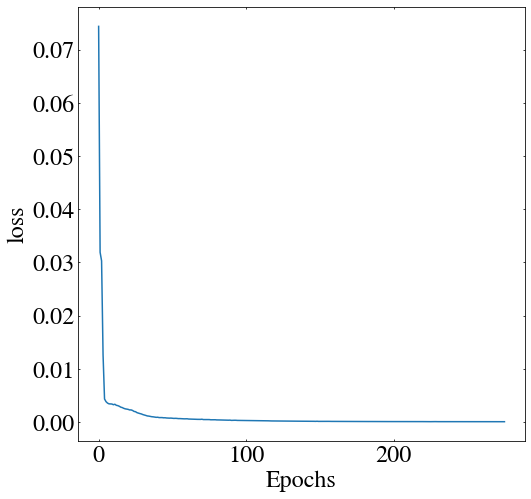


saving reconstruction_0.png


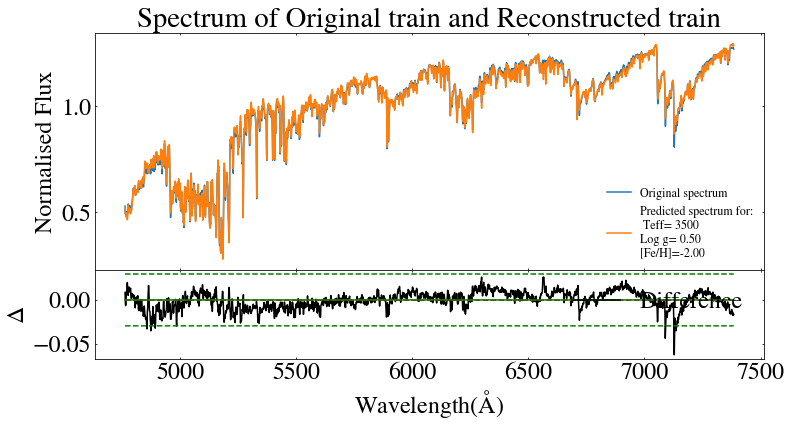


saving reconstruction_250.png


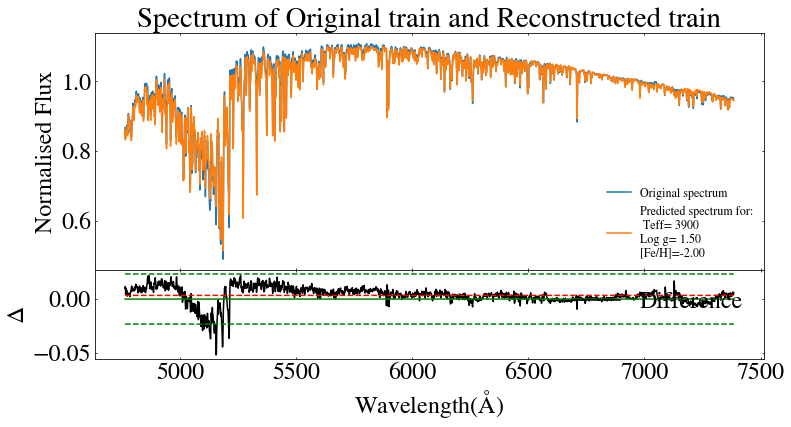


saving reconstruction_500.png


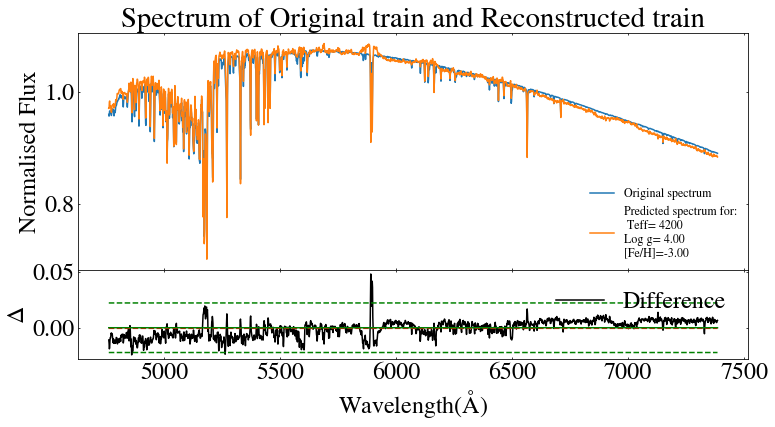


saving reconstruction_750.png


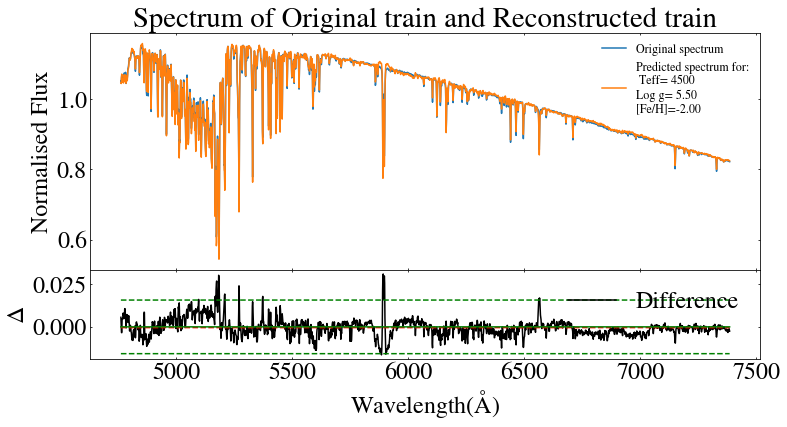


saving reconstruction_1000.png


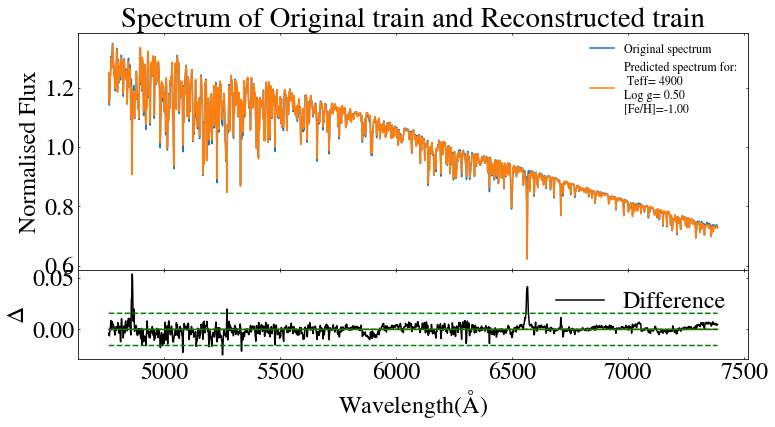


saving reconstruction_1250.png


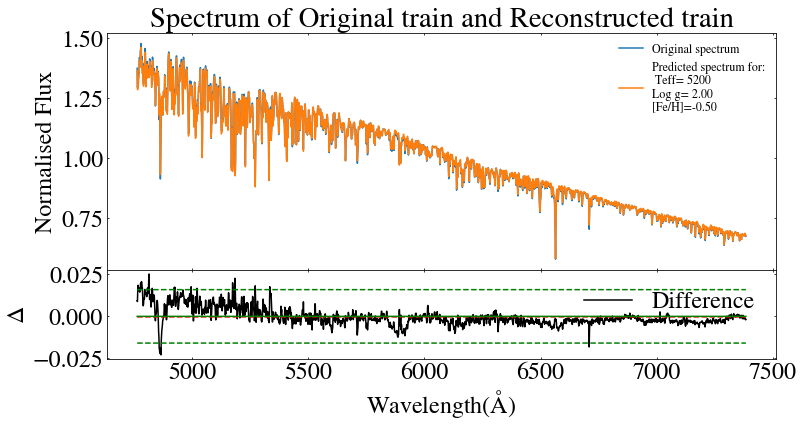


saving reconstruction_1500.png


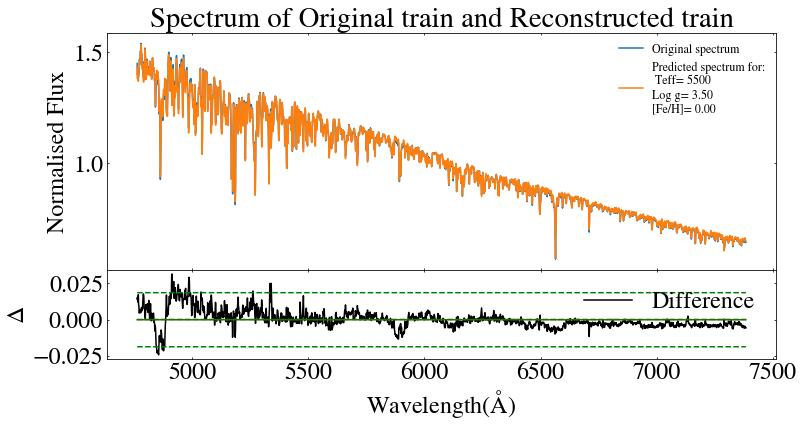


saving reconstruction_1750.png


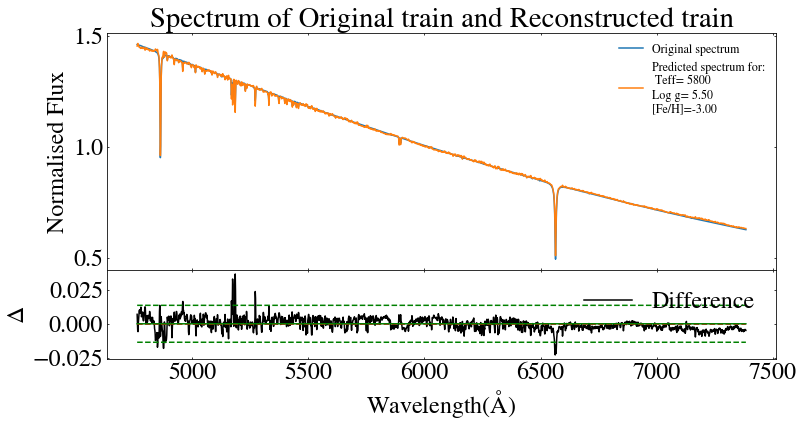


saving reconstruction_2000.png


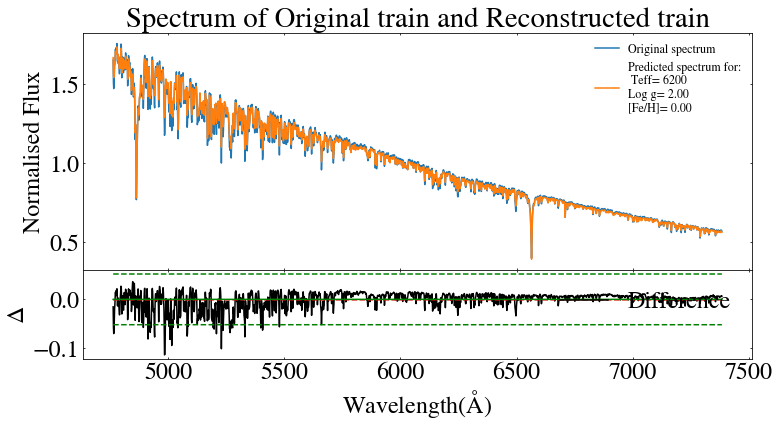


saving reconstruction_2250.png


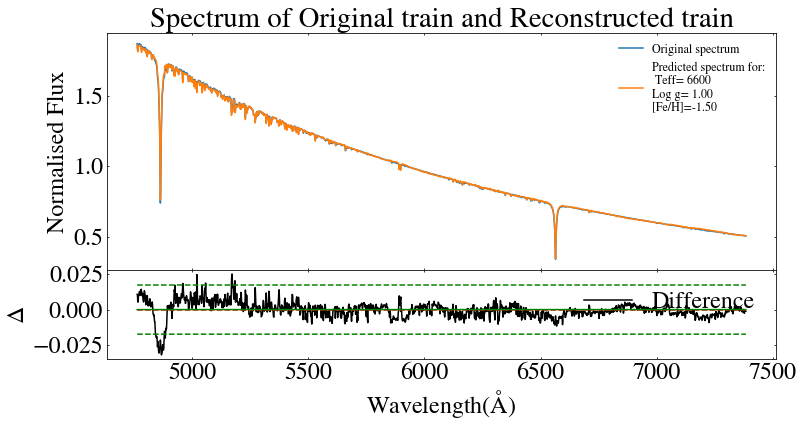


saving reconstruction_2500.png


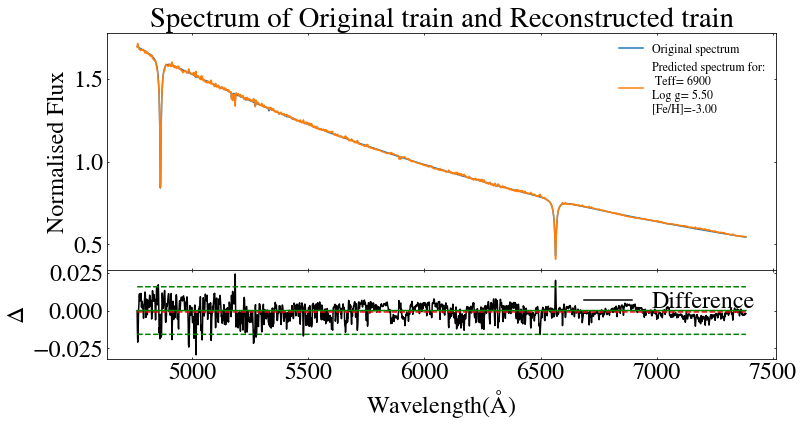


saving reconstruction_2750.png


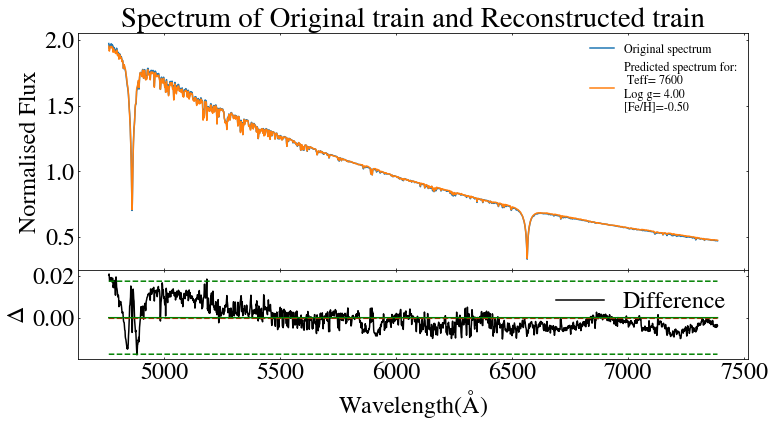



====================== Execution Done ===================================




In [4]:
print("%%%%%%%%%%%%%%% Training Started %%%%%%%%%%%%%%%%%%%\n")
annmodel = AnnModel(hidden_layers=[32, 128, 512], optimizer=tf.keras.optimizers.Adam(), tau=0.5)

t0 = time.time()
model = annmodel.train_model(X, y, var, epochs=10**3)
time_elapsed = time.time()-t0


history_df = pd.DataFrame(model.history.history)
history_df.to_csv('epoch_vs_loss.csv')


total_params = model.count_params()
print("\n\ntime to train:{} sec".format(time_elapsed))
print('\nTotal trainable parameters:{}'.format(total_params))

array = np.array([time_elapsed, total_params])
np.savetxt('time_and_total_params.txt', array)

##---- saving the model
save_model('toy_interpolator_v0.0.2_trial_1', model=model)
model.save('toy_interpolator_v0.0.2_trial_1.h5')


#saving plots
plot_loss(history_df, save=True)
plot(wl=wl, X=X, TGM=TGM, y=y, model=model, save=True)



with open('modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()
print("\n\n====================== Execution Done ===================================")
print('\n\n=========================================================================')